In [21]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shared_tools as tools
reload(tools)

class AgDegBW(object):
    
    def __init__(self,
                 friction = 'Manning',
                 Qf = 70,
                 If = 0.03,
                 B = 25,
                 L = 10000,
                 dx = 100,
                 S = 0.008,
                 Gtf = 700000,
                 D = 30,
                 porosity = 0.35,
                 kc = 75,
                 phi = 1,
                 alpha_r = 8.1,
                 alpha_t = 8.,
                 tau_c = 0.047,
                 nt = 1.5,
                 Cz = 22,
                 alpha_u = 0.5,
                 dt = 0.01,
                 totalT = 10,
                 g = 9.81,
                 rho_w = 1000,
                 rho_s = 2650):
    
    

        self.friction = friction

        self.Qf = float(Qf) # characteristic flood discharge
        self.If = float(If) # flood intermittency
        self.B = float(B) # channel width

        self.porosity = float(porosity)
        self.S = float(S)
        self.Gtf =  float(Gtf) # imposed annual sediment transport into reach
        self.L = float(L) # length of fluvial reach
        self.dx = float(dx)
        
        self.D_ = float(D)/1000
        self.kc_ = float(kc)/1000

        self.M = int(self.L/self.dx) # number of sub-reaches

        self.dt = float(dt) # years
        self.totalT = float(totalT)

        self.alpha_u = float(alpha_u) # upwind coefficient [1=full upwind, 0.5=central difference]
        self.phi = float(phi) # boundary shear stress due to skin friction (phi <= 1)
        self.alpha_r = float(alpha_r) # coefficient in Manning resistance relation

        # parameters for load relation (Wong and Parker, 2006)
        self.alpha_t = float(alpha_t) # coefficient in sed transport relation
        self.tau_c = float(tau_c)
        self.nt = float(nt) # exponent in sed transport relation

        # Chezy
        self.Cf = 1/float(Cz)**2

        # Constants
        self.g = float(g)
        self.sec_to_year = 60 * 60 * 24 * 365.25

        # Derivatives
        self.R = (float(rho_s) - float(rho_w)) / float(rho_w)


        # arrays
        self.x = np.array(range(self.M+1)) * self.dx
        self.eta = self.S*self.L - self.S*self.x
        self.eta[-1] = 0

        self.qb = np.zeros((self.M+1,), dtype = np.float)
        self.Sl = np.zeros_like(self.qb)
        self.tau = np.zeros_like(self.qb)
        self.Ht = np.zeros_like(self.qb)




    def calculate_ambient_equilibria(self):

        if self.friction == 'Manning':
            self.He = (self.Qf**2 * self.kc_**(1./3) / \
                      (self.alpha_r**2 * self.g * self.S * self.B**2))**(1./3)

        if self.friction == 'Chezy':
            self.He = (self.Qf**2 * self.Cf / (self.g * self.S * self.B**2)) ** (1./3)

        self.taustar = self.He * self.S / (self.R * self.D_)
        self.qstar = 0

        if (self.phi * self.taustar) > self.tau_c:
            self.qstar = self.alpha_t * (self.phi * self.taustar - self.tau_c)**self.nt
            self.qt = self.qstar * sqrt(self.g * self.R * self.D_) * self.D_
            self.Gt = self.qt * self.B * (1+self.R) * self.If * self.sec_to_year





    def calculate_ultimate_equilibria(self):    


        qtf = self.Gtf / (self.B * (1+self.R) * self.If * self.sec_to_year)
        self.tauult = (self.tau_c + (qtf / (self.alpha_t * sqrt(self.g * self.R * self.D_) *\
                        self.D_))**(1/self.nt)) / self.phi

        if self.friction == 'Manning':

            self.Sult = (self.R * self.D_ * self.tauult)**(10./7.) * \
                (self.alpha_r**2 * self.B**2 * self.g / (self.Qf**2 * self.kc_**(1./3)))**(3./7.)

        if self.friction == 'Chezy':

            self.Sult = (self.R * self.D_ * self.tauult * (self.g * self.B**2 / \
                (self.Qf**2 * self.Cf))**(1./3))**1.5

        self.Hult = self.R * self.D_ * self.tauult / self.Sult






    def advance_one_timestep(self):

        # Slope
        self.Sl = tools.central_difference(self.eta, self.dx)

        # Water depth
        if self.friction == 'Manning':   
            self.H = (self.Qf**2 * self.kc_**(1./3) / \
                      (self.alpha_r**2 * self.B**2 * self.g * self.Sl))**(3./10.)

        if self.friction == 'Chezy':
            
            self.H = (self.Qf**2 * self.Cf / (self.g * self.B**2 * self.Sl))**(1./3)

            
            
        # Shear stress
        self.tau = self.H * self.Sl / (self.R * self.D_)

        # Bed sediment load
        self.load = self.phi * self.tau - self.tau_c
        self.load[self.load <= 0] = 0
        self.load[self.load > 0] = self.alpha_t * self.load[self.load > 0]**self.nt

        self.qb = self.load * self.D_ * sqrt(self.R * self.g * self.D_)

        # Spatial derivative of sediment load
        qtf = self.Gtf / (self.B * (1+self.R) * self.If * self.sec_to_year)
        
        self.dq = tools.central_difference(self.qb,
                                          self.dx,
                                          alpha = self.alpha_u,
                                          right_boundary = qtf)
        self.dq[-1] = 0

        self.eta = self.eta + \
            (self.dt * self.sec_to_year / (1-self.porosity)) * self.If * self.dq




    def run(self):
        self.calculate_ambient_equilibria()
        self.calculate_ultimate_equilibria()

        for t in np.arange(0, self.totalT+self.dt, self.dt):

            self.advance_one_timestep()

            if (t)%2 == 0:
                print t
                plt.plot(self.x, self.eta)
                plt.show()

In [22]:
f = AgDegBW()

0.0


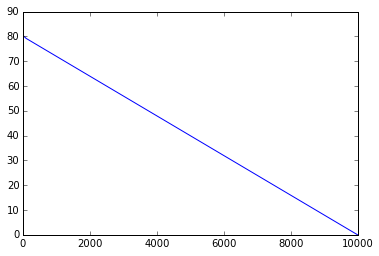

2.0


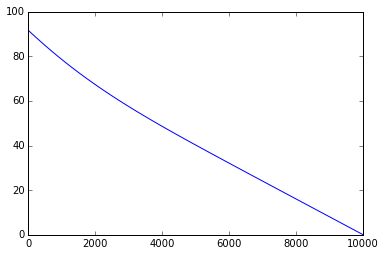

4.0


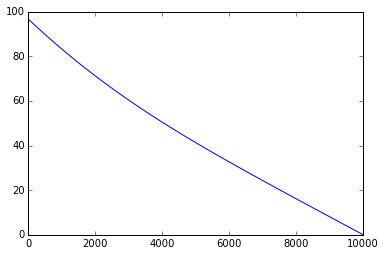

6.0


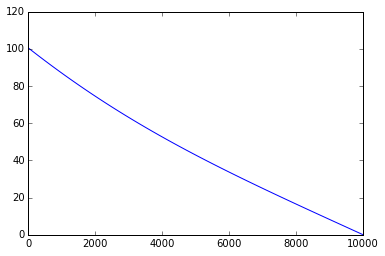

8.0


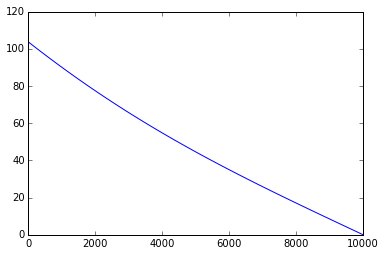

10.0


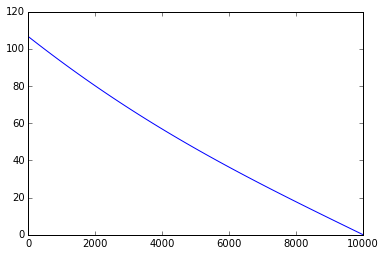

In [23]:
f.run()